# Ridge Regression Performance Model

In [660]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

from sklearn.preprocessing import QuantileTransformer

This notebook combines everything that learned in the previous notebooks into one performance model. Much of the data listed below is explored in much more detail in previous notebooks. I will note in each cell which notebook to look into for explanations.

In [661]:
# Reading in the training data. Storing the dataset as 
training = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [662]:
# Re-assigning column names
clean_columns = [column.replace(' ', '_').lower() for column in list(training.columns)]
training.columns = clean_columns
test.columns = clean_columns[:-1]

In [663]:
# Checking the shape
training.shape

(2051, 81)

In [664]:
# Removing some outliers. Commenting out some outliers to test their impact on my model. Refer to notebook 2.2.

training = training[training['gr_liv_area']<4000]
#training = training[training['1st_flr_sf']<3500]
training.drop([125, 1897], inplace=True)
#training = training[training['all_flr_sf']<3200]
training = training[training['garage_cars'] != 5]
training.drop([873, 554], inplace=True)
#training = training[training['mas_vnr_area'] < 1400]
#training = training[training['total_bsmt_sf'] < 3000]
#training = training[training['totrms_abvgrd'] < 13]
training = training[training['lot_area']<60000]
training = training[training['lot_frontage'] < 300]
#training[(training['neighborhood']==1) & (training['saleprice'] > 400000)]

In [665]:
# Selecting features. Refer to notebook 2.2.

features = ['overall_qual',  
            'exter_qual',
            'all_flr_sf', 
            'neighborhood',
            'kitchen_qual',
            'total_bsmt_sf', 
            'garage_area', 
            'year_built',
            'year_remod/add',
            'full_bath',
            'mas_vnr_area',
            'fireplaces', 
            'heating_qc',
            'bsmtfin_sf_1',
            'lot_area',
            'lot_frontage',
]

The cells below map and add features. Please refer to notebook 2.2 for more details.

In [666]:
# Mapping exter_quality
training['exter_qual'].replace({
                        'Po': 1,
                        'Fa': 2,
                        'TA': 3,
                        'Gd': 4,
                        'Ex': 5},
                        inplace=True
)

test['exter_qual'].replace({
                    'Po': 1,
                    'Fa': 2,
                    'TA': 3,
                    'Gd': 4,
                    'Ex': 5},
                    inplace=True
)

In [667]:
# Mapping kitchen_qual
training['kitchen_qual'].replace({
                            'Po': 1,
                            'Fa': 2,
                            'TA': 3,
                            'Gd': 4,
                            'Ex': 5},
                        inplace=True
)

test['kitchen_qual'].replace({
                        'Po': 1,
                        'Fa': 2,
                        'TA': 3,
                        'Gd': 4,
                        'Ex': 5},
                    inplace=True
)

In [668]:
# Creating all floor sqft feature
training['all_flr_sf'] = training['1st_flr_sf'] + training['2nd_flr_sf']
test['all_flr_sf'] = test['1st_flr_sf'] + test['2nd_flr_sf']

In [669]:
# Mapping heating quality to numeric.
training['heating_qc'] = \
            training['heating_qc'].replace({
                'Po': 0,
                'Fa': 1,
                'TA': 2,
                'Gd': 3,
                'Ex': 4
})

test['heating_qc'] = \
            test['heating_qc'].replace({
                'Po': 0,
                'Fa': 1,
                'TA': 2,
                'Gd': 3,
                'Ex': 4
})

In [670]:
# Mapping neighborhoods to desirability score
training['neighborhood'].replace({
                'MeadowV': 1,
                'IDOTRR': 1,
                'BrDale': 1,
                'OldTown': 1,
                'Edwards': 1,
                'BrkSide': 1,
                'Sawyer': 2,
                'SWISU': 2,
                'Landmrk': 2,
                'Blueste': 2,
                'NAmes': 2,
                'NPkVill': 2,
                'Mitchel': 2,
                'Gilbert': 3,
                'SawyerW': 3,
                'NWAmes': 3,
                'Greens': 3,
                'Blmngtn': 3,
                'Crawfor': 3,
                'CollgCr': 3,
                'ClearCr':  3,
                'Timber': 4,
                'Somerst': 4,
                'Veenker': 4,
                'GrnHill': 4,
                'NoRidge': 4,
                'StoneBr': 4,
                'NridgHt': 4},
        inplace = True)

test['neighborhood'].replace({
                'MeadowV': 1,
                'IDOTRR': 1,
                'BrDale': 1,
                'OldTown': 1,
                'Edwards': 1,
                'BrkSide': 1,
                'Sawyer': 2,
                'SWISU': 2,
                'Landmrk': 2,
                'Blueste': 2,
                'NAmes': 2,
                'NPkVill': 2,
                'Mitchel': 2,
                'Gilbert': 3,
                'SawyerW': 3,
                'NWAmes': 3,
                'Greens': 3,
                'Blmngtn': 3,
                'Crawfor': 3,
                'CollgCr': 3,
                'ClearCr':  3,
                'Timber': 4,
                'Somerst': 4,
                'Veenker': 4,
                'GrnHill': 4,
                'NoRidge': 4,
                'StoneBr': 4,
                'NridgHt': 4},
        inplace = True)

## Testing

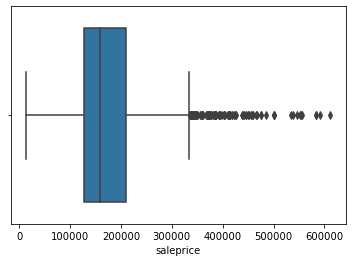

In [671]:
# Inspiration from Claire Hester and Minoo Taghavi
sns.boxplot(data=training, x='saleprice')
training = training[training['saleprice'] < 500000]

In [672]:
X = training[features]
y = training['saleprice']
test = test[features]

In [717]:
ridge_pipe = make_pipeline(KNNImputer(),                       
    StandardScaler(), 
    PolynomialFeatures(),                       
    SelectKBest(), 
    Ridge())

In [718]:
from sklearn import set_config
set_config(display='diagram')
ridge_pipe

Pipeline(steps=[('knnimputer', KNNImputer()),
                ('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('selectkbest', SelectKBest()), ('ridge', Ridge())])

In [691]:
# lr_pipe = make_pipeline(KNNImputer(),
#     StandardScaler(), 
#     PolynomialFeatures(), 
#     SelectKBest(), 
#     LinearRegression())

# lasso_pipe = make_pipeline(KNNImputer(),
#                            StandardScaler(), 
#                            PolynomialFeatures(),
#                            Lasso())

In [719]:
ridge_params = {
    'selectkbest__k': range(1, 81, 5),
    'ridge__fit_intercept': [True, False],
    'ridge__alpha': range(175, 250, 5)
          }

# best alpha 175 for range(150, 250)

In [707]:
# lr_params = {
#     'selectkbest__k': range(30, 200),
#     'linearregression__fit_intercept': [True, False],
#           }

# lasso_params = {
#     'lasso__fit_intercept': [True, False],
#     'lasso__alpha': range(550, 650)
#           }

In [720]:
gs = GridSearchCV(ridge_pipe, ridge_params, n_jobs=-1)

In [721]:
gs.fit(X, y)

/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [0] are constant.
  UserWarning)
/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


GridSearchCV(estimator=Pipeline(steps=[('knnimputer', KNNImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest', SelectKBest()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': range(175, 250, 5),
                         'ridge__fit_intercept': [True, False],
                         'selectkbest__k': range(1, 81, 5)})

Training Score 0.9203590876825025
RMSE Training 21430.57306360015
{'ridge__alpha': 175, 'ridge__fit_intercept': True, 'selectkbest__k': 76}


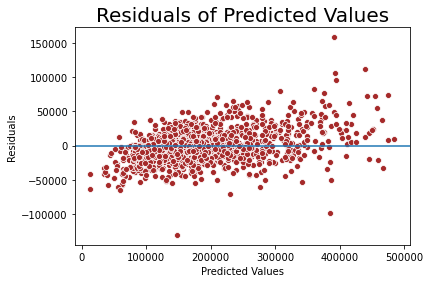

In [727]:
# Scoring the model

print('Training Score', gs.score(X, y))
print('RMSE Training', mean_squared_error(y, gs.predict(X), squared=False))
print(gs.best_params_)

preds = gs.predict(X)
resids = np.array(y) - preds
sns.scatterplot(x=y, y=resids, color='brown')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline();
plt.title('Residuals of Predicted Values', fontsize=20)
plt.savefig('./assets/Ridge Residuals')

I have found that the Ridge Linear Regression is the best model for predicting house sale prices in Ames, Iowa. My model had an R2 score of .9381 and a RMSE of 18892 for the training data. Per the residual plot above, there are a few predictions that my model guessed a high value but infact it was much lower. The best model hyperparameters ended up being an alpha of 175 and SelectKBest chose 148 of the 150 features including the polynomials. 

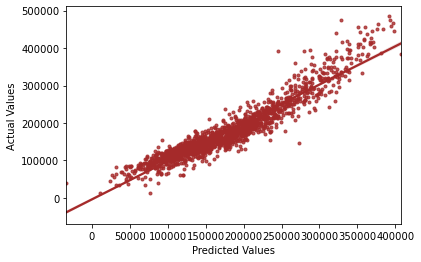

In [711]:
sns.regplot(x=preds, y=y, marker='.', color='brown')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

In [712]:
# Creating predictions CSV
test_preds = gs.predict(test)
test1 = pd.read_csv('./datasets/test.csv')
submission= pd.DataFrame(test_preds, index=test1['Id'])
submission.columns = ['saleprice']

In [683]:
#Exporting predictions CSV
submission.to_csv('./datasets/submission.csv')

In [722]:
# Finding coefficients and feature names and creating a sorted coefficient dataframe
coefs = gs.best_estimator_.named_steps['ridge'].coef_
feature_names = gs.best_estimator_.named_steps['selectkbest'].get_support()

X_cols = gs.best_estimator_.named_steps['polynomialfeatures'].get_feature_names(X.columns)
feature_names_array = np.array(X_cols)[feature_names==True]

coefs_df = pd.DataFrame({'Feature Names': feature_names_array,'Coefficients': coefs})

sorted_coefs_df = coefs_df.sort_values(by='Coefficients')

In [723]:
# Creating a dataframe of the top 5 and bottom 5 coefficients
limited_coefs_df = pd.concat([sorted_coefs_df.head(5), sorted_coefs_df.tail(5)])

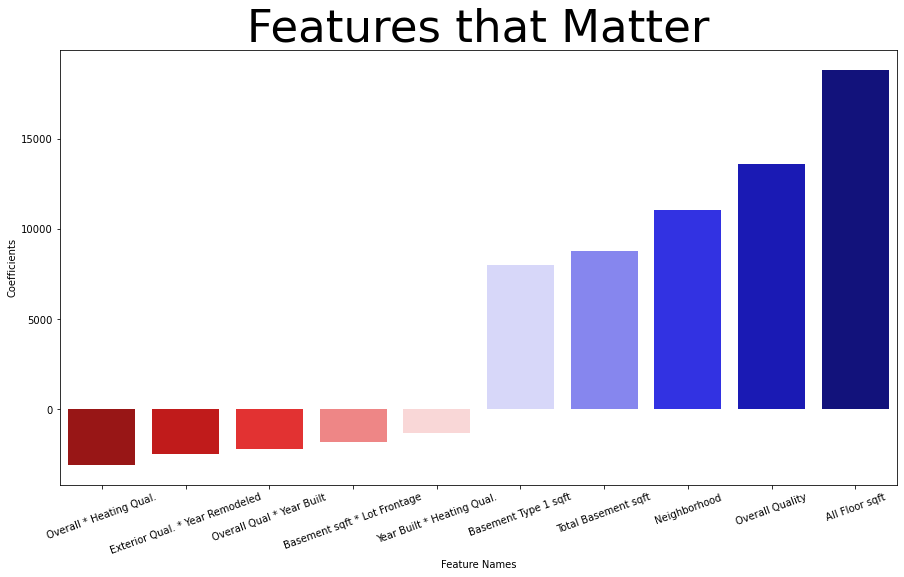

In [732]:
# Graphing the coefs.
plt.figure(figsize=(15, 8))
g = sns.barplot(data=limited_coefs_df, x='Feature Names', y='Coefficients', palette='seismic_r')
plt.title('Features that Matter', fontsize=(45))
g.set_xticks(range(10))
g.set_xticklabels(['Overall * Heating Qual.','Exterior Qual. * Year Remodeled','Overall Qual * Year Built','Basement sqft * Lot Frontage','Year Built * Heating Qual.','Basement Type 1 sqft', 'Total Basement sqft', 'Neighborhood', 'Overall Quality', 'All Floor sqft'])
plt.xticks(rotation=20)
plt.savefig('./assets/prettygraph.png');

In [735]:
coefs_df.sort_values(by='Coefficients')

,Feature Names,Coefficients
23,overall_qual heating_qc,-3076.790956
18,overall_qual year_built,-2469.444868
60,total_bsmt_sf^2,-2191.957828
58,kitchen_qual lot_area,-1817.854023
48,neighborhood kitchen_qual,-1315.031657
...,...,...
6,garage_area,7988.469334
3,neighborhood,8774.708351
5,total_bsmt_sf,11068.266194
0,overall_qual,13586.017821
